In [1]:
%matplotlib inline 

from collections import defaultdict, namedtuple
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy.stats import poisson

In [2]:
RENTAL_LAMBDA1 = 3
RENTAL_LAMBDA2 = 4

RETURN_LAMBDA1 = 3
RETURN_LAMBDA2 = 2

COST_OF_MOVING = 2
COST_OF_RENTAL = 10

DISCOUNT_RATE = 0.9

MAX_N_CARS = 20
MAX_N_MOVING_CARS = 5

POISSON_CUTOFF = 15

In [3]:
ACTIONS = tuple(range(-MAX_N_MOVING_CARS, MAX_N_MOVING_CARS + 1))
State = namedtuple("State",  "loc1 loc2")
STATES = tuple([State(i, j) for i in range(MAX_N_CARS + 1) for j in range(MAX_N_CARS + 1)])

#### Policy evaluation

Function $v_{\pi}(s)$ for a policy $\pi$ is equal to $E_{\pi}[R_{t+1}|S_{t}=s]$ + $\gamma$ $E_{\pi}[v_{\pi}(S_{t+1})|S_{t}=s]$. <br>According to policy evaluation algorithm we can just take the last update to $v_{\pi}(s^{'})$ (if we know $s^{'}$). First let's focus on $E_{\pi}[R_{t+1}]$, let's derive an useful recipe for computing it: <br><br>
$E_{\pi}[R_{t+1}|S_{t}=s]$ = $\sum_{a}E_{\pi}[R_{t+1}|S_{t}=s, A_{t}=a]Pr(A_{t}=a|S_{t}=s)$ =
$\pi(s)E_{\pi}[R_{t+1}|S_{t}=s, A_{t}=a]$ <br>(since we're considering only deterministic policies).<br><br>

$S_{t}$ represents the number of cars in both location at the end of the day. Acting $A_{t}=a$ means transfering some cars from one location to another. 

We can create map ("state", "action") -> "expected reward" to speed up computations later 

In [4]:
def get_expected_return_table():
    expected_return_table = {}
    
    for current_state in STATES:
        for action in ACTIONS:
            if action >= 0: # move loc1 -> loc2
                possible_movement = min(action, current_state.loc1)
                state_loc1 = current_state.loc1 - possible_movement
                state_loc2 = current_state.loc2 + possible_movement
                state_loc2 = min(state_loc2, MAX_N_CARS)
            else: # move loc2 -> loc1 
                possible_movement = min(abs(action), current_state.loc2)
                state_loc2 = current_state.loc2 - possible_movement 
                state_loc1 = current_state.loc1 + possible_movement
                state_loc1 = min(state_loc1, MAX_N_CARS)

            expected_revenue = -abs(action) * COST_OF_MOVING

            for n_rentals1 in range(POISSON_CUTOFF):
                for n_rentals2 in range(POISSON_CUTOFF):
                    p = poisson.pmf(n_rentals1, mu=RENTAL_LAMBDA1) * poisson.pmf(n_rentals2, mu=RENTAL_LAMBDA2)
                    possible_rental1 = min(state_loc1, n_rentals1)
                    possible_rental2 = min(state_loc2, n_rentals2)
                    possible_rentals = possible_rental1 + possible_rental2

                    expected_revenue += p * possible_rentals * COST_OF_RENTAL
            
            expected_return_table[(current_state, action)] = expected_revenue
            
    return expected_return_table

In [5]:
%%time 
expected_return_table = get_expected_return_table()

Wall time: 2min 20s


In [6]:
len(expected_return_table) # 441 * 11 

4851

Now, let's consider $E_{\pi}[v_{\pi}(S_{t+1})|S_{t}=s]$. Let's derive an useful expression for it: <br><br>
$E_{\pi}[v_{\pi}(S_{t+1})|S_{t}=s]$ = $E_{\pi}[v_{\pi}(S_{t+1})|S_{t}=s, A_{t}=a]$. Since we are considering deterministic policies. Next: <br><br>
$E_{\pi}[v_{\pi}(S_{t+1})|S_{t}=s, A_{t}=a]$ = $\sum_{s^{'}}E_{\pi}[v_{\pi}(s^{'})|S_{t}=s, A_{t}=a, S_{t+1}=s^{'}]$$Pr(S_{t+1}=s^{'}|S_{t}=s, A_{t}=a)$ = $\sum_{s^{'}}v_{\pi}(s^{'})$$Pr(S_{t+1}=s^{'}|S_{t}=s, A_{t}=a)$. 

Below we compute map (state, action) -> List([0, probability], ..., [20, probability]), 
where integers correspond to a number of cars at a location at the end of the day. 

In [7]:
def get_transition_probability_table(first_location: bool):
    transition_probability_table = defaultdict(dict)
    
    for current_state in STATES:
        for action in ACTIONS:
            if action >= 0: # move loc1 -> loc2
                possible_movement = min(action, current_state.loc1)
                state_loc1 = current_state.loc1 - possible_movement
                state_loc2 = current_state.loc2 + possible_movement
                state_loc2 = min(state_loc2, MAX_N_CARS)
            else: # move loc2 -> loc1 
                possible_movement = min(abs(action), current_state.loc2)
                state_loc2 = current_state.loc2 - possible_movement 
                state_loc1 = current_state.loc1 + possible_movement
                state_loc1 = min(state_loc1, MAX_N_CARS)

            if first_location:
                current_state_morning = state_loc1
            else:
                current_state_morning = state_loc2

            for n_rentals in range(POISSON_CUTOFF):
                for n_returns in range(POISSON_CUTOFF):
                    if first_location:
                        p = poisson.pmf(n_rentals, mu=RENTAL_LAMBDA1) * poisson.pmf(n_returns, mu=RETURN_LAMBDA1)
                    else:
                        p = poisson.pmf(n_rentals, mu=RENTAL_LAMBDA2) * poisson.pmf(n_returns, mu=RETURN_LAMBDA2)

                    current_state_morning = max(0, current_state_morning - n_rentals)
                    next_loc = min(MAX_N_CARS, current_state_morning + n_returns)

                    old_p = transition_probability_table[(current_state, action)].get(next_loc, 0)
                    transition_probability_table[(current_state, action)][next_loc] = old_p + p
                            
    return dict(transition_probability_table)

In [8]:
%%time
transition_prob_table1 = get_transition_probability_table(True)
transition_prob_table2 = get_transition_probability_table(False)

Wall time: 4min 33s


In [9]:
def policy_evaluation(
    value_function: np.ndarray, 
    policy: np.ndarray, 
    expected_return_table: Dict[Tuple[State, int], float] = expected_return_table,
    transition_prob_table1: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table1,
    transition_prob_table2: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table2,
    epsilon: float = 1e-4
):
    """
    Args:
        value_function: of shape (MAX_N_CARS + 1, MAX_N_CARS + 1). At (i, j) value function at state (i, j)
        policy: of shape (MAX_N_CARS + 1, MAX_N_CARS + 1). At [i, j] action to take at state (i, j)
        expected_return_table:
        transition_prob_table1:
        transition_prob_table2: 
        epsilon: a small number, criterion for stopping 
    Return: 
        Estimated value function for given policy 
    """
    value_function = value_function.copy()
    policy = policy.copy()
    i = 1
    
    while True:
        delta = 0
        for current_state in STATES:
            old_v = value_function[current_state.loc1, current_state.loc2]
            action = policy[current_state.loc1, current_state.loc2]
            
            immediate_reward = expected_return_table[(current_state, action)]
            
            v_ahead = 0 
            for next_loc1, p1 in transition_prob_table1[(current_state, action)].items():
                for next_loc2, p2 in transition_prob_table2[(current_state, action)].items():
                    v_ahead += p1 * p2 * value_function[next_loc1, next_loc2]
                  
            value_function[current_state.loc1, current_state.loc2] = immediate_reward + DISCOUNT_RATE * v_ahead

            delta = max(delta, abs(value_function[current_state.loc1, current_state.loc2] - old_v))
    
        print("[iter] = {}, delta = {}".format(i, delta))
        if delta < epsilon:
            return value_function
        i += 1 

In [10]:
def policy_improvement(
    value_function: np.ndarray, 
    policy: np.ndarray, 
    expected_return_table: Dict[Tuple[State, int], float] = expected_return_table,
    transition_prob_table1: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table1,
    transition_prob_table2: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table2,
):
    """Greedily computes new policy based on given value function."""
    policy_stable = True
    policy = policy.copy()
    value_function = value_function.copy()
    
    for current_state in STATES:
        old_action = policy[current_state.loc1, current_state.loc2]
        best_action = -10000
        best_value = -10000
        
        for action in ACTIONS:    
            action_value = 0
            for next_loc1, p1 in transition_prob_table1[(current_state, action)].items():
                for next_loc2, p2 in transition_prob_table2[(current_state, action)].items():
                    action_value += p1 * p2 * value_function[next_loc1, next_loc2]
            
            action_value += expected_return_table[(current_state, action)]
            
            if action_value > best_value:
                best_action = action
                best_value = action_value
        
        policy[current_state.loc1, current_state.loc2] = best_action
        
        if old_action != policy[current_state.loc1, current_state.loc2]:
            policy_stable = False 
            
    return policy, policy_stable

In [11]:
def policy_iteration(
    value_function: np.ndarray, 
    policy: np.ndarray, 
    expected_return_table: Dict[Tuple[State, int], float] = expected_return_table,
    transition_prob_table1: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table1,
    transition_prob_table2: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table2,
):
    """Policy iteration algorihtm."""
    value_function = value_function.copy()
    policy = policy.copy()
        
    policy_stable = False
    i = 1
    policies = [policy]
    
    while not policy_stable:
        print('[iteration] = {}'.format(i))
        value_function = policy_evaluation(value_function, policy)
        policy, policy_stable = policy_improvement(value_function, policy)
        policies.append(policy)
        i += 1 
        
    return policies

In [12]:
def plot_policy(policy: np.ndarray):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(policy[::-1], cmap=plt.cm.jet, aspect='auto')
    plt.xlabel('# of Cars at location 1')
    plt.ylabel('# of Cars at location 2')
    plt.xticks(np.arange(0, policy.shape[0], 1))
    plt.yticks(np.arange(0, policy.shape[1], 1))
    plt.colorbar()

In [13]:
v0 = np.zeros((MAX_N_CARS + 1, MAX_N_CARS + 1))
p0 = np.zeros_like(v0, dtype=int)

In [14]:
%%time
policies = policy_iteration(v0, p0)

[iteration] = 1
[iter] = 1, delta = 133.16090037562026
[iter] = 2, delta = 62.86462365903135
[iter] = 3, delta = 53.29246009255287
[iter] = 4, delta = 45.407193268682434
[iter] = 5, delta = 37.252419199088564
[iter] = 6, delta = 30.373017982892662
[iter] = 7, delta = 24.75381885490185
[iter] = 8, delta = 20.175298776442872
[iter] = 9, delta = 16.4439241198599
[iter] = 10, delta = 13.402681152843343
[iter] = 11, delta = 10.9239033766342
[iter] = 12, delta = 8.903566111517705
[iter] = 13, delta = 7.25688302286801
[iter] = 14, delta = 5.914748154116523
[iter] = 15, delta = 4.82083638714812
[iter] = 16, delta = 3.9292397354417403
[iter] = 17, delta = 3.202540733331375
[iter] = 18, delta = 2.6102421433150766
[iter] = 19, delta = 2.12748708418502
[iter] = 20, delta = 1.734015867058588
[iter] = 21, delta = 1.4133157609103364
[iter] = 22, delta = 1.1519280059553694
[iter] = 23, delta = 0.9388829924685638
[iter] = 24, delta = 0.7652399012682167
[iter] = 25, delta = 0.6237114860857673
[iter] = 2

In [15]:
len(policies)

4

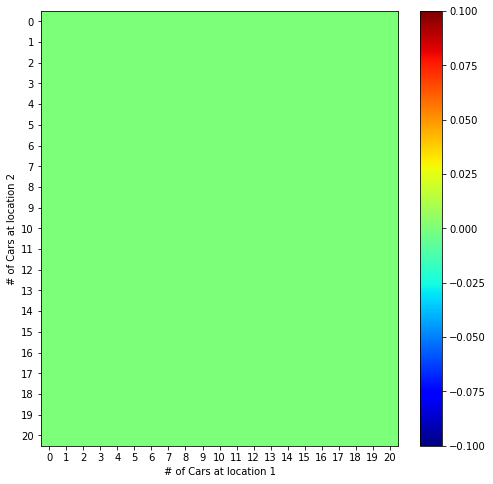

In [17]:
plot_policy(policies[0])

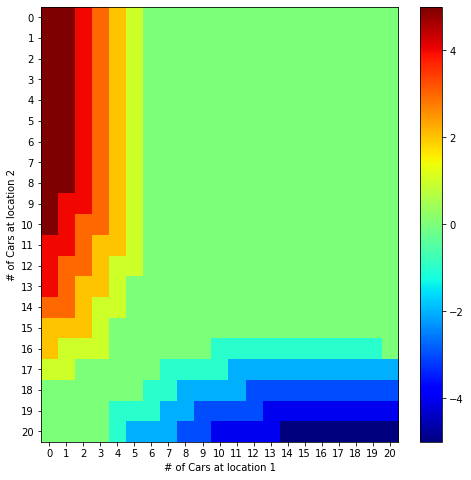

In [18]:
plot_policy(policies[1])

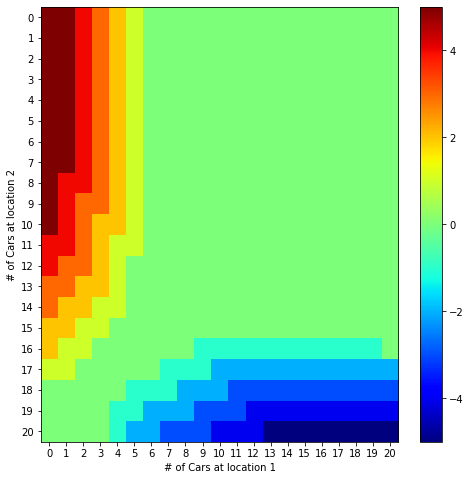

In [19]:
plot_policy(policies[2])

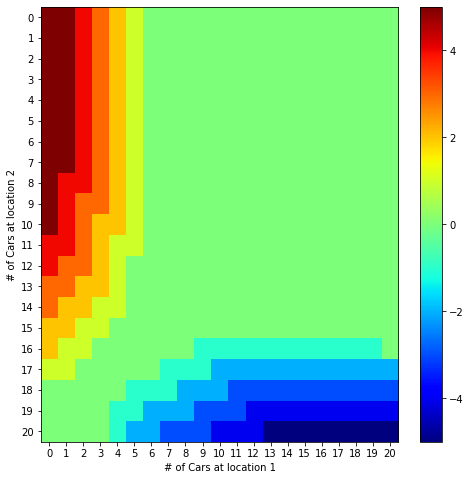

In [20]:
plot_policy(policies[3])